# Preprocessing - RAVDESS
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

This notebook implements the preprocessing steps on the RAVDESS dataset.
- This dataset is used for testing the model.
- Only audio speech samples of the dataset (in "RAVDESS/(Actor Number)") are considered.
- GPU is not used.

The sections are as follows -
- [Dataset](#dataset)
- [Load Files](#load_files)
- [Imports](#imports)
- [Data Extraction](#data_extraction)
- [Audio Preprocessing](#audio_preprocessing)
- [Audio Augmentation](#audio_augmentation)
- [Conversion to Spectrogram](#conversion_to_spectrogram)
- [Spectrogram Augmentation](#spectrogram_augmentation)
- [Save Files](#save_files)

<a id='dataset'></a>
## Dataset
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) vocalizes two lexically-matched statements in
a neutral North American accent.

- Audio data includes singing and normal voice.
- The database is annotated by multiple annotators.

| Information | Description |
| :-- | :-: |
| **Type** | Simulated |
| **Features** | 8 emotions<br>2 intensity levels<br>2 repititions<br>3.7 second average length<br>2496 samples<br>24 speakers (12 male and 12 female) |
| **Emotions** | Angry<br>Calm<br>Disgust<br>Fearful<br>Happy<br>Neutral<br>Sad<br>Surprised |
| **Intensities** | Normal<br>Strong |

<a id='load_files'></a>
## Load Files
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

Loading the RAVDESS dataset, preprocessing module, visualization module, and helper module into the session storage (for use in Colab).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/RAVDESS Data.zip' 'RAVDESS Data.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/preprocessing.zip' 'preprocessing.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/visualization.zip' 'visualization.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/helper.zip' 'helper.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/network.zip' 'network.zip'

!unzip 'RAVDESS Data.zip'
!unzip 'preprocessing.zip'
!unzip 'visualization.zip'
!unzip 'helper.zip'
!unzip 'network.zip'

!pip install torchmetrics

Mounted at /content/gdrive
Archive:  RAVDESS Data.zip
   creating: RAVDESS Data/Actor_01/
  inflating: RAVDESS Data/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: RAVDESS Data/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: RAVDESS Data/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: RAVDESS Data/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: RAVDESS Data/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: RAVDESS Data/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: RAVDESS Data/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: RAVDESS Data/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: RAVDESS Data/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: RAVDESS Data/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: RAVDESS Data/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: RAVDESS Data/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: RAVDESS Data/Actor_01/03-01-03-01-01-01-01.wav  
  inflating: RAVDESS Data/Actor_01/03-01-03-01-01-02-01.wav  
  inflating: RAVDESS Data/Actor_01/03-01-0

<a id='imports'></a>
## Imports
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
Importing the required functions from the preprocessing module.
> `split` - code for splitting dataset into required subsets.
<br>
> `multiprocessing` - code for implementing multiprocessing tasks.
<br>
> `ravdess` - code for specific functions on the RAVDESS dataset.

In [ ]:
import sys
sys.path.append('./preprocessing')

from preprocessing.split import stratified_test_split, stratified_valid_split, make_k_folds, create_subsets
from preprocessing.multiprocessing import multi_audio_aug, multi_audio_to_spec, multi_spec_aug
from preprocessing.ravdess import get_files, extract_information, validate_labels, load_audio_files

#### Step 2:
Importing the required functions from the visualization module.
> `exploration` - code for conducting exploratory visualizations.

In [ ]:
sys.path.append('./visualization')

from visualization.exploration import plot_ravdess_distributions, plot_audio, plot_spectrogram_aug
from visualization.exploration import plot_trimmed_audio, plot_duration, plot_audio_aug, plot_spectrogram

#### Step 3:
- Importing the required functions from the helper module.
  > `common` - code for general-purpose functions common among all modules.<br>
  > `preprocessing` - code for general-purpose functions of preprocessing module.<br>
  > `visualization` - code for general-purpose functions of visualization module.

- Importing additional libraries.

In [ ]:
sys.path.append('./helper')

from helper.common import save_data
from helper.preprocessing import trim_audio_files, compute_audio_length, class_to_int, drop_labels, create_dir
from helper.visualization import get_dataframe, show_dataframe 

import os

<a id='data_extraction'></a>
## Data Extraction
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
- Defining the root directory, dataset name, data mappings, and class labels.

In [ ]:
root = './RAVDESS Spectrograms'
name = 'ravdess'

int_to_emotion = {1: 'Neutral', 2: 'Calm', 3: 'Happy', 4: 'Sad', 5: 'Angry', 6: 'Fearful', 7: 'Disgust', 8: 'Surprised'}
int_to_stmt = {1: 'Kids are talking by the door', 2: 'Dogs are sitting by the door'}

class_labels = ['Angry', 'Calm', 'Disgust', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprised']

#### Step 2:
- Extracting the file names.
- Extracting the labels **[categorical = emotion, gender, and intensity]** and details **[statement and repitition]**.
> All are extracted from file names.
- Validation of the extracted labels by checking if emotion lies in `class_labels`, gender in **['Male', 'Female']**, and intensity in **['Normal', 'Strong']**.

In [ ]:
files = get_files()
label_data, detail_data = extract_information(files, int_to_emotion, int_to_stmt)
validate_labels(label_data, class_labels)

All labels are valid.


#### Step 3:
Displaying `label_data` and `detail_data`.

In [ ]:
label_df = get_dataframe(label_data, name, 'label')
detail_df = get_dataframe(detail_data, name, 'detail')

print(f'Number of Samples: {len(files)}\n')
show_dataframe(label_df, 'label', num_rows = 5)
show_dataframe(detail_df, 'detail', num_rows = 5)

Number of Samples: 1440


-------------Label Data-------------


,File Name,Emotion,Gender,Intensity
0,03-01-05-01-02-02-01,Angry,Male,Normal
1,03-01-08-01-02-02-01,Surprised,Male,Normal
2,03-01-07-01-01-02-01,Disgust,Male,Normal
3,03-01-02-01-02-02-01,Calm,Male,Normal
4,03-01-03-01-02-01-01,Happy,Male,Normal



-------------Detail Data-------------


,File Name,Statement,Repitition
0,03-01-05-01-02-02-01,Dogs are sitting by the door,2
1,03-01-08-01-02-02-01,Dogs are sitting by the door,2
2,03-01-07-01-01-02-01,Kids are talking by the door,2
3,03-01-02-01-02-02-01,Dogs are sitting by the door,2
4,03-01-03-01-02-01-01,Dogs are sitting by the door,1


#### Spec 4:
Plotting label distributions of samples.

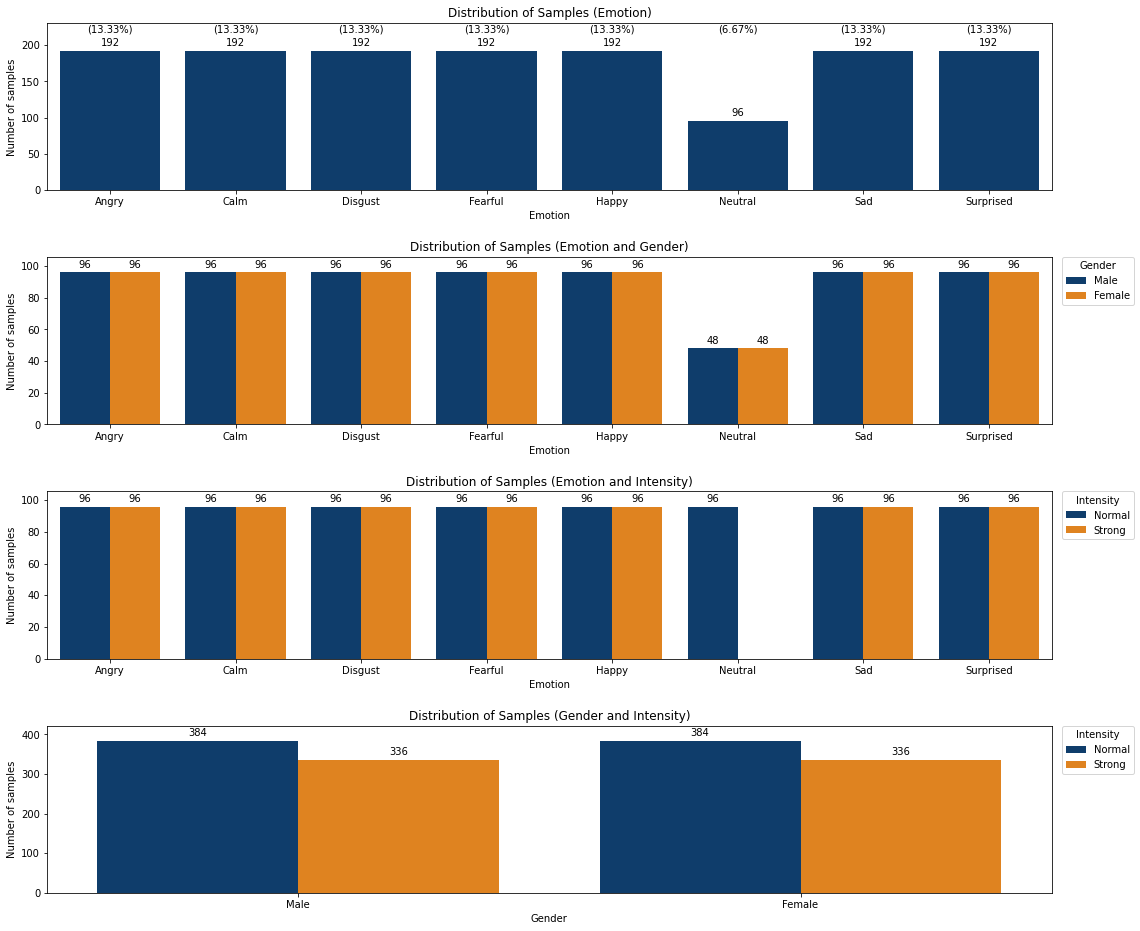

In [ ]:
plot_ravdess_distributions(label_df, class_labels)

#### Step 5:
- Defining the dropped labels and removing data pertaining to them from `class_labels`, `label_data`, `detail_data`, and `files`.
- Creation of required directories i.e. root, test, train, audio, emotion folders etc.

In [ ]:
to_drop = ['Calm', 'Disgust']

drop_labels(class_labels, to_drop, label_data, detail_data, files)
create_dir(root, class_labels, name)

print(f'Number of Samples: {len(files)}\n')

Number of Samples: 1056



#### Step 6:
- Loading the audio files from the RAVDESS dataset (sample rate and time-series of amplitude).

- Plotting the audio waveforms.
    > `label` - label of audio.<br>
    > `num_samples` - number of samples to plot.<br>
    > `playable` - if playable audio should be displayed.

In [ ]:
audio_data = load_audio_files(files)

1: 03-01-06-01-02-01-02 | Fearful | Female | Normal


2: 03-01-06-02-01-02-15 | Fearful | Male | Strong


3: 03-01-06-01-02-01-13 | Fearful | Male | Normal


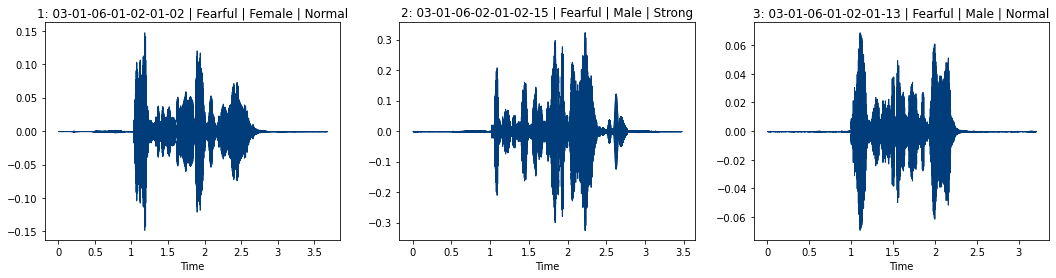

In [ ]:
plot_audio(label_df, audio_data, name, label = 'Fearful', num_samples = 3, playable = True)

<a id='audio_preprocessing'></a>
## Audio Preprocessing
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
- Computing durations of the audio samples and storing them in `detail_data`.
- Trimming the leading and trailing silence.
    > Threshold level below which input is considered as silence is **40 db**.
- Computing durations of the trimmed audio samples and storing them in `detail_data`.

In [ ]:
compute_audio_length(audio_data, detail_data)
trimmed_audio_data = trim_audio_files(audio_data, top_db = 40)
compute_audio_length(trimmed_audio_data, detail_data)

#### Step 2:
Plotting the trimmed audio waveforms.
> `num_samples` - number of samples to plot.<br>
> `playable` - if playable audio should be displayed.

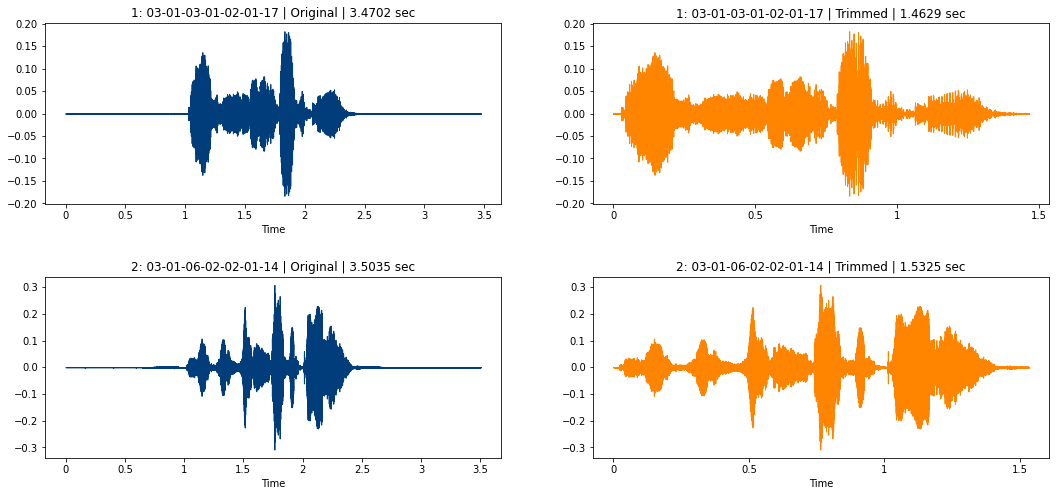

In [ ]:
detail_df = get_dataframe(detail_data, name, 'detail')
plot_trimmed_audio(detail_df, audio_data, trimmed_audio_data, num_samples = 2, playable = False)

#### Step 3:

Plotting the duration distribution of samples.

-------------Original Duration-------------
Maximum: 5.11 sec
Minimum: 2.97 sec
Average: 3.64 sec

-------------Trimmed Duration-------------
Maximum: 4.40 sec
Minimum: 1.21 sec
Average: 2.04 sec


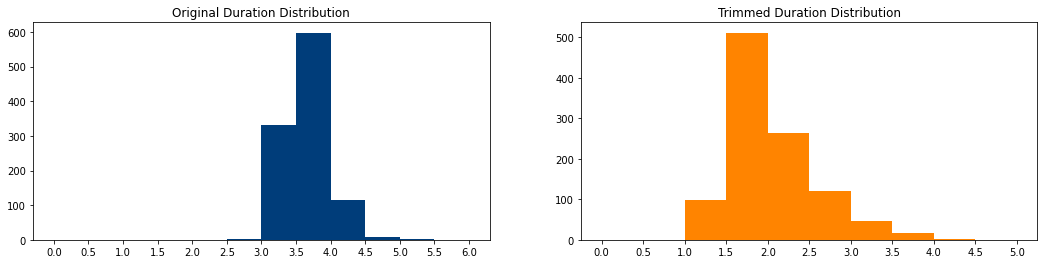

In [ ]:
plot_duration(detail_df, bin_size = 0.5)

#### Step 4:
Creating a dictionary of split data (to stay consistent with IEMOCAP Notebook).
> No split takes place for RAVDESS, all files belong to `test` split.

In [ ]:
split_data = {}
split_data['test'] = list(files)

<a id='audio_augmentation'></a>
## Audio Augmentation
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
Creating subsets of audio data.
> Subsets are required so that operations are performed on 1 subset at a time due to **memory limitations**. Each subset has a maximum of **1000** original samples.

> `num_subsets` - number of subsets of data.

In [ ]:
num_subsets = create_subsets(root, trimmed_audio_data, 'test', size = 1000)

#### Step 2:
Defining the audio augmentation. For every audio sample, 3 augmentations are made:
- Addition of white noise (by a factor of **0.075**).
- Time stretch (by a factor of either **0.75 or 1.25**).
- Pitch shift (by a factor of either **-1 or 1 semitones**).

In [ ]:
augment_factors = [0.075, [0.75, 1.25], [-1, 1]]

#### Step 3:
Augmentation of the audio samples in each subset. This involves -
- Loading a subset.
- Augmenting the audio.
- Saving the augmented audio of that subset.

> The augmentation function is assigned to a seperate `process` using the `multiprocessing` module to ensure that resources (mainly RAM) are relinquished when function has finished execution.

In [ ]:
multi_audio_aug(root, 'test', augment_factors, num_subsets)

IntProgress(value=0, description='Subset - 0 / 2', layout=Layout(width='500px'), max=2, style=ProgressStyle(de…

#### Step 4:
Plotting the augmented audio waveforms of a random sample.
> `playable` - if playable audio should be displayed.

1: 03-01-06-01-01-02-05 | Original


2: 03-01-06-01-01-02-05 | Noise Addition


3: 03-01-06-01-01-02-05 | Time Stretch


4: 03-01-06-01-01-02-05 | Pitch Shift


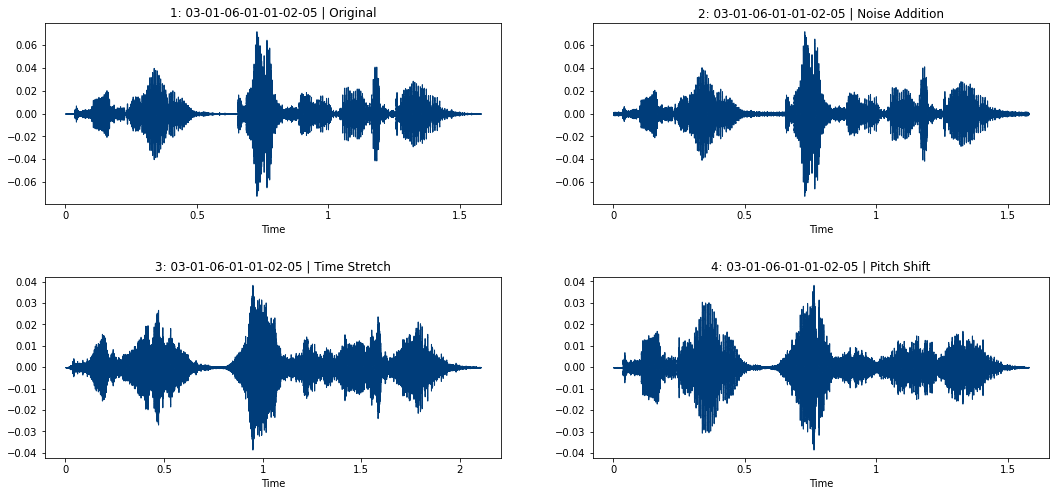

In [ ]:
plot_audio_aug(root, 'test', num_subsets, playable = True)

<a id='conversion_to_spectrogram'></a>
## Conversion to Spectrogram
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">


#### Overview
- A Log Mel Spectrogram is a visual representation of signal strength at different frequencies over time. 
- It provides a perceptual representation of amplitude (decibels) and frequency (mel scale) i.e., in a non-linear (logarithmic) manner. 
- This is also how our ears distance sounds. Sounds of equal distance from each other on the mel scale are also percieved by humans as being equal in distance from one another.

It is prepared through the following steps - 
- Sample the input with windows of size `n_fft` and make hops of size `hop_length`.
- Compute the Fast Fourier Transform for each window to transform from time domain to frequency domain.
- Separate the frequency spectrum into `n_mels`(bins) with evenly spaced frequencies (non-linear distance). Each bin is transformed into a corresponding bin in the mel scale.
- For each window, take the dot product of the magnitude and the corresponding transformed frequency, to obtain a new scale.

#### Step 1:
Converting audio samples to spectrograms (**256*256** pixels in size). This involves -
- Loading a subset.
- Converting subset samples to spectrograms with 3 (RGB) channels.
- Saving in **png format**.

> Values for spectrogram generation are -<br>
> `n_fft` - 2048.<br>
> `hop_length` - 512.<br>
> `n_mels` - 256.

> The conversion function is assigned to a seperate `process` using the `multiprocessing` module to ensure that resources (mainly RAM) are relinquished when function has finished execution.

In [ ]:
spec_params = [2048, 512, 256]

In [ ]:
multi_audio_to_spec(root, label_data, 'test', spec_params, num_subsets)

IntProgress(value=0, description='Subset - 0 / 2', layout=Layout(width='500px'), max=2, style=ProgressStyle(de…

#### Step 2:
Plotting a spectrogram of an original audio sample from each label.
> `playable` - if playable audio should be displayed.

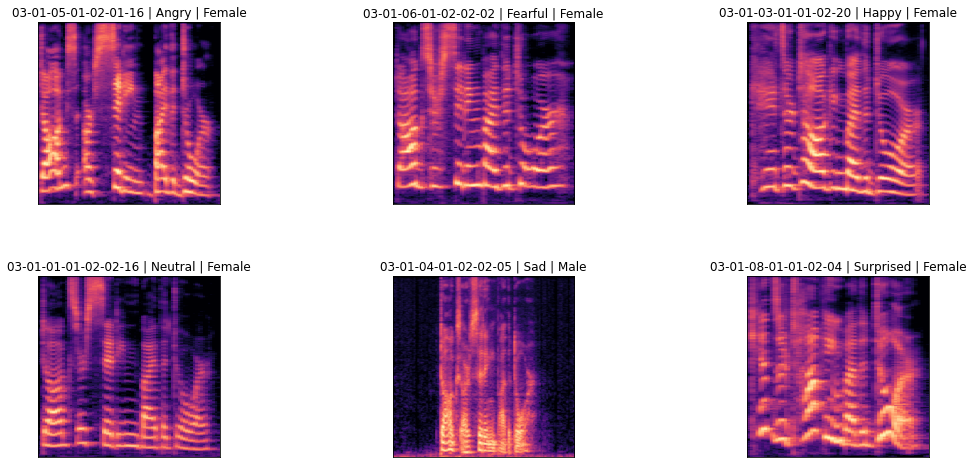

In [ ]:
plot_spectrogram(root, split_data, 'test', label_data, class_labels, name)

<a id='spectrogram_augmentation'></a>
## Spectrogram Augmentation
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
Defining the spectrogram augmentation. 
> Frequency masking and Time masking (with mask parameter between **10 and 20**) are performed on the spectrogram of each audio sample. 

> Frequency channels $[f_0, f_0 + f)$ are masked.<br>
> - $f$ is chosen from a uniform distribution from **10** to **20** (the frequency mask parameter $F$).<br>
> - $f_0$ is chosen from $(0, ν − f)$ where $ν$ is the number of frequency channels.

> t consecutive time steps $[t_0, t_0 + t)$ are masked.<br>
> - $t$ is chosen from a uniform distribution from **10** to **20** (the frequency mask parameter $T$).<br>
> - $t_0$ is chosen from $(0, \tau − t)$ where $\tau$ is the time steps.

In [ ]:
augment_width = [10, 20]

#### Step 2:
Augmenting the spectrogram images, one subset at a time, and saving in **png format**. This involves - 
- Loading a subset.
- Augmenting the spectrogram.
- Saving in **png format**.

> The augmentation function is assigned to a seperate `process` using the `multiprocessing` module to ensure that resources (mainly RAM) are relinquished when function has finished execution.

In [ ]:
multi_spec_aug(root, label_data, 'test', augment_width, num_subsets)     

IntProgress(value=0, description='Subset - 0 / 2', layout=Layout(width='500px'), max=2, style=ProgressStyle(de…

#### Step 3:
Plotting the augmented spectrograms.
> `num_sample` - number of samples to plot.

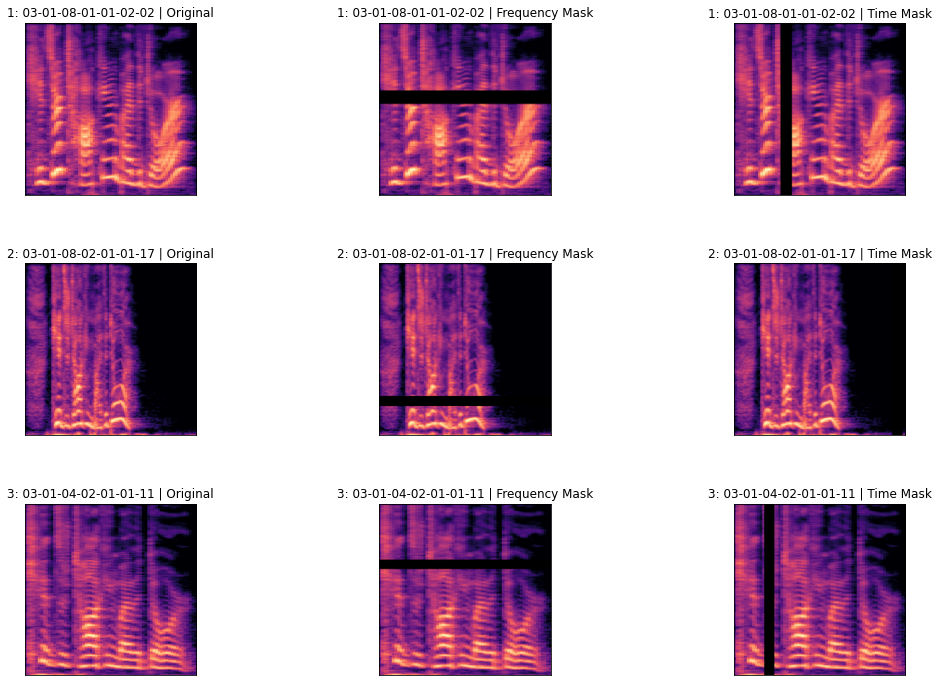

In [ ]:
plot_spectrogram_aug(root, split_data, 'test', label_data, num_samples = 3)

Each audio sample will therefore have **5 augmentations** in total.

<a id='save_files'></a>
## Save Files
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

Saving the `RAVDESS Meta` folder and the `RAVDESS Spectrogram` folder (from Colab session storage). Additionally, removing the `Audio` folder.
> `class_data` - dictionary that maps labels to integers.<br>
> `RAVDESS Spectrogram` - contains the spectrograms generated in this notebook.<br>
> `RAVDESS Meta` - contains the metadata generated in this notebook.

In [ ]:
class_data = class_to_int(class_labels, name)

meta_root = './RAVDESS Meta'
os.mkdir(meta_root)

save_data(meta_root, detail_data, 'Detail')
save_data(meta_root, label_data, 'Label')
save_data(meta_root, split_data, 'Split')
save_data(meta_root, class_data, 'Class')

In [ ]:
!rm -rf './RAVDESS Spectrograms/Audio'
!zip -r '/content/gdrive/My Drive/Speech Emotion Recognition Project/RAVDESS Meta.zip' 'RAVDESS Meta'
!zip -r '/content/gdrive/My Drive/Speech Emotion Recognition Project/RAVDESS Spectrograms.zip' 'RAVDESS Spectrograms'

Streaming output truncated to the last 5000 lines.
  adding: RAVDESS Spectrograms/Test/Fearful/03-01-06-02-01-01-10/03-01-06-02-01-01-10_aug1.png (deflated 0%)
  adding: RAVDESS Spectrograms/Test/Fearful/03-01-06-02-01-01-10/03-01-06-02-01-01-10_aug2.png (deflated 0%)
  adding: RAVDESS Spectrograms/Test/Fearful/03-01-06-02-01-01-10/03-01-06-02-01-01-10_aug3.png (deflated 0%)
  adding: RAVDESS Spectrograms/Test/Fearful/03-01-06-02-01-01-10/03-01-06-02-01-01-10_aug6.png (deflated 0%)
  adding: RAVDESS Spectrograms/Test/Fearful/03-01-06-02-01-01-10/03-01-06-02-01-01-10_aug5.png (deflated 0%)
  adding: RAVDESS Spectrograms/Test/Fearful/03-01-06-02-01-01-10/03-01-06-02-01-01-10_aug4.png (deflated 0%)
  adding: RAVDESS Spectrograms/Test/Fearful/03-01-06-02-02-02-21/ (stored 0%)
  adding: RAVDESS Spectrograms/Test/Fearful/03-01-06-02-02-02-21/03-01-06-02-02-02-21_aug1.png (deflated 0%)
  adding: RAVDESS Spectrograms/Test/Fearful/03-01-06-02-02-02-21/03-01-06-02-02-02-21_aug3.png (deflated 0%)